In [1]:
import os
import random
from time import time
from tqdm import tqdm
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
import joblib

from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms, models
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Subset

from collections import defaultdict
from contextlib import contextmanager

import time

from PIL import Image
import csv

from sklearn.metrics import precision_score
from sklearn.metrics import precision_recall_fscore_support

from collections import Counter

C:\Users\anson\AppData\Local\Temp\ipykernel_17612\4111777933.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
c:\Users\anson\Documents\Projects\Python\AI_Art_Curation_System\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data Load

In [2]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to a fixed size
    transforms.ToTensor(),          # Convert images to tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def custom_dataloader(data_dir, transform, batch_size=64, num_workers=1):

  '''
  input:
    data_dir: file path of input data. raw_dataset are created from that file
    batch_size
    num_workers
  output:
    train_loader, val_loader, test_loader
  -----
  data is transformed by data_transform. train:val:test = 0.8:0.1:0.1 with each classes equally splitted
    '''

  raw_dataset = datasets.ImageFolder(root=data_dir, transform=transform)
  print(raw_dataset)
  num_classes = len(raw_dataset.classes)
  print("Number of classes:", num_classes)
  np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
  indices = np.arange(len(raw_dataset))
  np.random.shuffle(indices)
  train_split = int(len(indices) * 0.8)
  testval_split = train_split + int(len(indices) * (1 - 0.8)/2)
  # split into training and validation indices
  relevant_train_indices, relevant_val_indices,test_indices = indices[:train_split], indices[train_split:testval_split] ,indices[testval_split:]
  train_sampler = SubsetRandomSampler(relevant_train_indices)
  train_loader = torch.utils.data.DataLoader(raw_dataset, batch_size=batch_size,
                                             num_workers=num_workers, sampler=train_sampler)
  val_sampler = SubsetRandomSampler(relevant_val_indices)
  val_loader = torch.utils.data.DataLoader(raw_dataset, batch_size=batch_size,
                                            num_workers=num_workers, sampler=val_sampler)
  test_sampler = SubsetRandomSampler(test_indices)
  test_loader = torch.utils.data.DataLoader(raw_dataset, batch_size=batch_size,
                                           num_workers=num_workers, sampler=test_sampler)
  print(f'data loading completed')
  return train_loader, val_loader, test_loader

In [3]:
def count_classes(loader):
    class_counts = defaultdict(int)
    for _, labels in loader:
        for label in labels:
            class_counts[label.item()] += 1
    return class_counts

def data_class_analysis(train_loader, val_loader, test_loader):
  '''
  input: train_loader, val_loader, test_loader
  output: class_df-dataframe that contains number of data in each class for each train, val, test loader.
  '''
  # Count classes for each loader
  train_class_counts = count_classes(train_loader)
  val_class_counts = count_classes(val_loader)
  test_class_counts = count_classes(test_loader)

  # Create a DataFrame
  class_data = {'Train': train_class_counts, 'Validation': val_class_counts, 'Test': test_class_counts}
  class_df = pd.DataFrame(class_data).fillna(0).sort_index()  # Fill NaN values with 0

  # Print or display the DataFrame
  print(class_df)
  return class_df

In [4]:
unzipped_dir = 'E:/wikiART224'

In [22]:
train_loader, val_loader, test_loader = custom_dataloader(unzipped_dir, transform, batch_size=128)
#class_df = data_class_analysis(train_loader, val_loader, test_loader)

Dataset ImageFolder
    Number of datapoints: 75788
    Root location: E:/wikiART224
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
Number of classes: 19
data loading completed


In [7]:
used_class = [
    'Abstract_Expressionism',
    'Art_Nouveau_Modern',
    'Baroque',
    'Cubism',
    'Early_Renaissance',
    'Expressionism',
    'High_Renaissance',
    'Impressionism',
    'Mannerism_Late_Renaissance',
    'Minimalism',
    'Naive_Art_Primitivism',
    'Northern_Renaissance',
    'Post_Impressionism',
    'Realism',
    'Rococo',
    'Romanticism',
    'Symbolism',
    'Ukiyo_e'
]

# Define model

In [10]:
class StyleResNet50(nn.Module):
  def __init__(self):
    super(StyleResNet50, self).__init__()
    resnet = models.resnet50(pretrained=True)
        # Freeze all parameters in ResNet
    for param in resnet.parameters():
      param.requires_grad = False
    # Get the number of input features of the last layer in ResNet
    num_features = resnet.fc.in_features
        
    # Remove the last fully connected layer of ResNet
    modules = list(resnet.children())[:-1]
    self.resnet = nn.Sequential(*modules)
    
    self.fc1 = nn.Linear(num_features, 19)
    self.dropout = nn.Dropout(p=0.5)

  def forward(self, x):
    x = self.resnet(x)
    x = x.view(x.size(0), -1)
    x = self.dropout(x)
    x = self.fc1(x)

    return x

In [11]:
class StyleResNet50_1(nn.Module):
  def __init__(self):
    super(StyleResNet50_1, self).__init__()
    resnet = models.resnet50(pretrained=True)
        # Freeze all parameters in ResNet
    for param in resnet.parameters():
      param.requires_grad = False
    # Get the number of input features of the last layer in ResNet
    num_features = resnet.fc.in_features
        
    # Remove the last fully connected layer of ResNet
    modules = list(resnet.children())[:-1]
    self.resnet = nn.Sequential(*modules)
    
    self.fc1 = nn.Linear(num_features, 19)
    self.dropout = nn.Dropout(p=0.3)

  def forward(self, x):
    x = self.resnet(x)
    x = x.view(x.size(0), -1)
    x = self.dropout(x)
    x = self.fc1(x)

    return x

In [12]:
import torch.nn.functional as F

class StyleResNet50_2(nn.Module):
    def __init__(self, num_classes=19, prob=0.5):
        super(StyleResNet50_2, self).__init__()
        resnet = models.resnet50(pretrained=True)
            # Freeze all parameters in ResNet
        for param in resnet.parameters():
            param.requires_grad = False
        # Get the number of input features of the last layer in ResNet
        num_features = resnet.fc.in_features
        # Remove the last fully connected layer of ResNet
        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        # Add Dropout
        self.dropout = nn.Dropout(prob)
        # Add two fully connected layers with dropout and Leaky ReLU
        self.fc1 = nn.Linear(num_features, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.1, inplace=True)
        
    def forward(self, x):
        x = self.resnet(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.leaky_relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Training

In [20]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"device: {device}")

device: cuda


In [14]:
def plot_curves(train_losses, valid_losses, train_accuracies, valid_accuracies, elapsed_time):
    print(f'elapsed time: {elapsed_time}')
    iterations = range(1, len(train_losses) + 1)
    # Plot Loss Curve
    plt.figure(figsize=(10, 5))
    plt.plot(iterations, train_losses, label='Train Loss', color='blue')
    plt.plot(iterations, valid_losses, label='Validation Loss', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
    epochs = range(1, len(train_accuracies) + 1)
    # Plot Accuracy Curve
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_accuracies, label='Train Accuracy', color='blue')
    plt.plot(epochs, valid_accuracies, label='Validation Accuracy', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

In [15]:
def evaluate_model(model, data_loader, device):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    criterion = nn.CrossEntropyLoss()
    with torch.no_grad():

        for data, labels in data_loader:
          data, labels = data.to(device), labels.to(device)
          output = model(data)
          loss = criterion(output, labels)
          total_loss += loss.item() * data.size(0)
          #pred = (output > 0.0).squeeze().long()
          #total_correct += (pred == labels).sum().item()
          pred = output.max(1, keepdim=True)[1]
          total_correct += pred.eq(labels.view_as(pred)).sum().item()
          total_samples += data.size(0)

    accuracy = total_correct / total_samples
    average_loss = total_loss / total_samples

    return average_loss, accuracy

In [16]:
def train_model(model, model_name, train_loader, valid_loader, device, num_epochs=4, lr=0.0001, wd=0, clip_gradient=None):
    train_losses = []
    valid_losses = []
    train_accuracies = []
    valid_accuracies = []
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.train()

    optimizer = Adam(model.parameters(), lr=lr, weight_decay=wd)
    criterion = nn.CrossEntropyLoss()

    start_time = time.time()
    for epoch in range(num_epochs):

        running_loss = 0.0
        running_pred = 0.0
        running_total = 0.0
        tqdm_bar = tqdm(train_loader)

        for batch_idx, (inputs, labels) in enumerate(tqdm_bar):
            with torch.set_grad_enabled(True):
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                loss.backward()
                if clip_gradient is not None:
                    torch.nn.utils.clip_grad_norm_(model.parameters(), clip_gradient)
                optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                pred = outputs.max(1, keepdim=True)[1]
                running_pred += pred.eq(labels.view_as(pred)).sum().item()
                running_total += pred.shape[0]


        train_acc = running_pred / running_total
        train_loss = running_loss / running_total
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        running_loss = 0.0
        running_pred = 0.0
        running_total = 0.0
        valid_loss, valid_acc = evaluate_model(model, valid_loader, device)
        valid_losses.append(valid_loss)
        valid_accuracies.append(valid_acc)
        print(f'Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx+1}/{len(train_loader)}], '
              f'Training Loss: {train_loss:.4f}, Training Accuracy: {train_acc:.4f}, '
              f'Validation Loss: {valid_loss:.4f}, Validation Accuracy: {valid_acc:.4f}')
        model.train()
        
        joblib.dump(model, f'C:\\Users\\anson\\Documents\\Projects\\Python\\AI_Art_Curation_System\\outputs\\{model_name}_epoch{epoch+1}.joblib')

        results = pd.DataFrame({'train loss': train_losses, 'valid loss': valid_losses, 'train accuracy': train_accuracies, 'valid accuracy': valid_accuracies})
        results.to_csv(f'C:\\Users\\anson\\Documents\\Projects\\Python\\AI_Art_Curation_System\\outputs\\{model_name}_results.csv')
    end_time = time.time()
    elapsed_time = end_time - start_time
    plot_curves(train_losses, valid_losses, train_accuracies, valid_accuracies, elapsed_time)


    return model, train_losses, valid_losses, train_accuracies, valid_accuracies

##TRAIN WIkiART224

100%|██████████| 948/948 [03:21<00:00,  4.71it/s]


Epoch [1/3], Step [948/948], Training Loss: 2.2930, Training Accuracy: 0.2671, Validation Loss: 2.0203, Validation Accuracy: 0.3502


100%|██████████| 948/948 [03:15<00:00,  4.84it/s]


Epoch [2/3], Step [948/948], Training Loss: 2.0049, Training Accuracy: 0.3504, Validation Loss: 1.8830, Validation Accuracy: 0.4006


100%|██████████| 948/948 [03:34<00:00,  4.41it/s]


Epoch [3/3], Step [948/948], Training Loss: 1.9203, Training Accuracy: 0.3737, Validation Loss: 1.8201, Validation Accuracy: 0.4092
elapsed time: 697.9665925502777


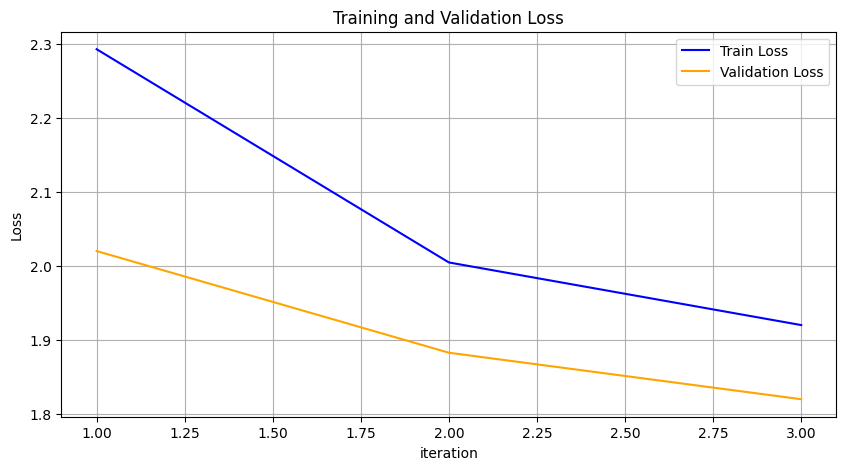

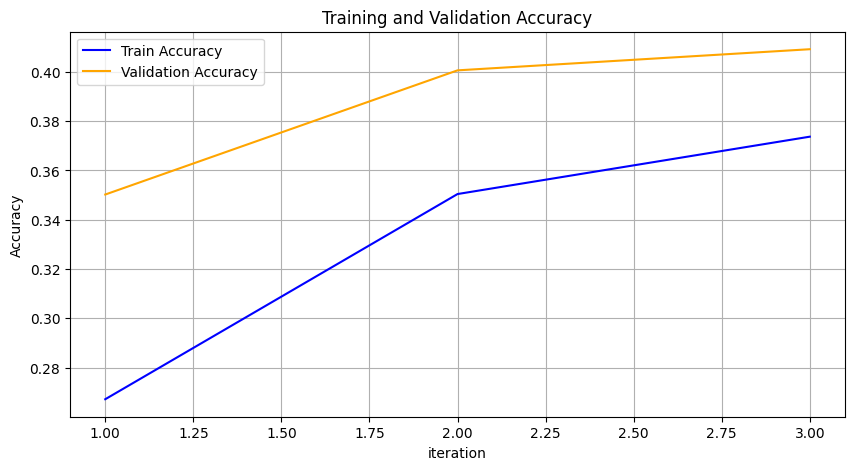

In [22]:
model = StyleResNet50()
trained_model, train_losses, valid_losses, train_accuracies, valid_accuracies = train_model(model, 'model_50', train_loader, val_loader, device, num_epochs = 3, clip_gradient=1.0)

c:\Users\anson\Documents\Projects\Python\AI_Art_Curation_System\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\anson\Documents\Projects\Python\AI_Art_Curation_System\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 948/948 [03:35<00:00,  4.40it/s]


Epoch [1/5], Step [948/948], Training Loss: 2.3048, Training Accuracy: 0.2596, Validation Loss: 2.0333, Validation Accuracy: 0.3622


100%|██████████| 948/948 [03:23<00:00,  4.66it/s]


Epoch [2/5], Step [948/948], Training Loss: 2.0120, Training Accuracy: 0.3509, Validation Loss: 1.8911, Validation Accuracy: 0.3965


100%|██████████| 948/948 [03:50<00:00,  4.12it/s]


Epoch [3/5], Step [948/948], Training Loss: 1.9256, Training Accuracy: 0.3722, Validation Loss: 1.8304, Validation Accuracy: 0.4105


100%|██████████| 948/948 [04:12<00:00,  3.76it/s]


Epoch [4/5], Step [948/948], Training Loss: 1.8779, Training Accuracy: 0.3858, Validation Loss: 1.7911, Validation Accuracy: 0.4233


100%|██████████| 948/948 [03:57<00:00,  4.00it/s]


Epoch [5/5], Step [948/948], Training Loss: 1.8527, Training Accuracy: 0.3918, Validation Loss: 1.7631, Validation Accuracy: 0.4314
elapsed time: 1281.8921661376953


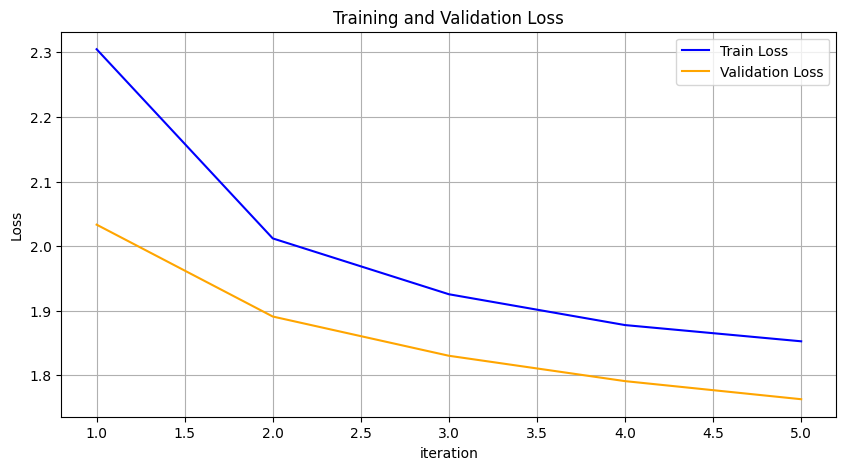

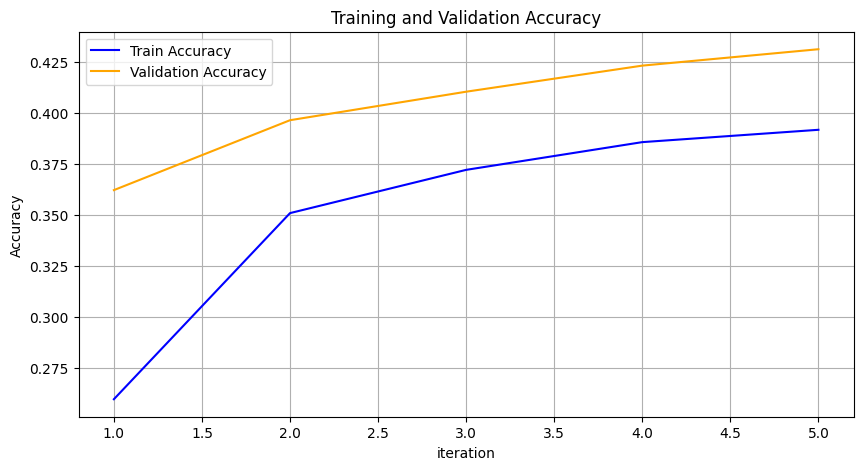

In [23]:
model = StyleResNet50()
trained_model, train_losses, valid_losses, train_accuracies, valid_accuracies = train_model(model, 'model_50', train_loader, val_loader, device, num_epochs = 5, clip_gradient=None)

100%|██████████| 948/948 [04:08<00:00,  3.82it/s]


Epoch [1/5], Step [948/948], Training Loss: 2.0304, Training Accuracy: 0.3403, Validation Loss: 1.7743, Validation Accuracy: 0.4137


100%|██████████| 948/948 [04:02<00:00,  3.91it/s]


Epoch [2/5], Step [948/948], Training Loss: 1.9360, Training Accuracy: 0.3679, Validation Loss: 1.7522, Validation Accuracy: 0.4219


100%|██████████| 948/948 [04:08<00:00,  3.82it/s]


Epoch [3/5], Step [948/948], Training Loss: 1.9366, Training Accuracy: 0.3684, Validation Loss: 1.8084, Validation Accuracy: 0.4099


100%|██████████| 948/948 [03:14<00:00,  4.87it/s]


Epoch [4/5], Step [948/948], Training Loss: 1.9298, Training Accuracy: 0.3735, Validation Loss: 1.7613, Validation Accuracy: 0.4117


100%|██████████| 948/948 [03:08<00:00,  5.02it/s]


Epoch [5/5], Step [948/948], Training Loss: 1.9335, Training Accuracy: 0.3707, Validation Loss: 1.7152, Validation Accuracy: 0.4274
elapsed time: 1272.9721336364746


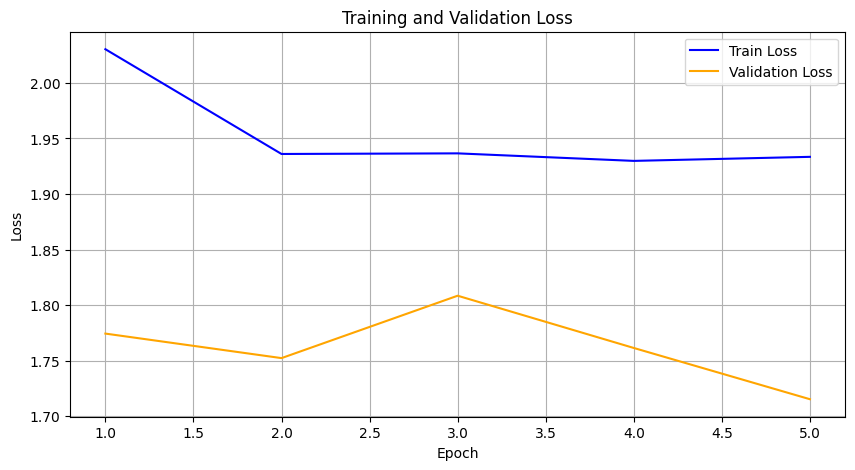

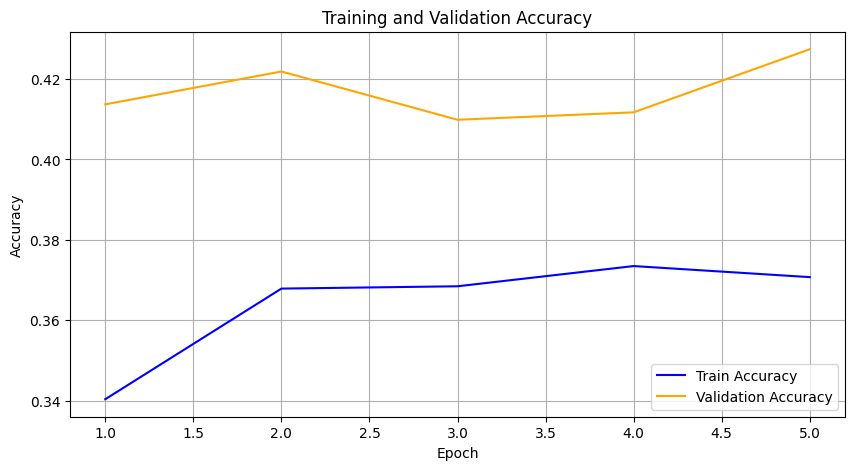

In [26]:
model = StyleResNet50()
trained_model, train_losses, valid_losses, train_accuracies, valid_accuracies = train_model(model, 'model_50_lr001', train_loader, val_loader, device,lr=0.001, num_epochs = 5, clip_gradient=None)

c:\Users\anson\Documents\Projects\Python\AI_Art_Curation_System\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\anson\Documents\Projects\Python\AI_Art_Curation_System\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 948/948 [04:09<00:00,  3.80it/s]


Epoch [1/5], Step [948/948], Training Loss: 2.2365, Training Accuracy: 0.2845, Validation Loss: 1.9855, Validation Accuracy: 0.3758


100%|██████████| 948/948 [04:14<00:00,  3.73it/s]


Epoch [2/5], Step [948/948], Training Loss: 1.9428, Training Accuracy: 0.3769, Validation Loss: 1.8559, Validation Accuracy: 0.4087


100%|██████████| 948/948 [04:14<00:00,  3.73it/s]


Epoch [3/5], Step [948/948], Training Loss: 1.8570, Training Accuracy: 0.3963, Validation Loss: 1.7980, Validation Accuracy: 0.4162


100%|██████████| 948/948 [03:26<00:00,  4.59it/s]


Epoch [4/5], Step [948/948], Training Loss: 1.8112, Training Accuracy: 0.4068, Validation Loss: 1.7673, Validation Accuracy: 0.4264


100%|██████████| 948/948 [03:15<00:00,  4.85it/s]


Epoch [5/5], Step [948/948], Training Loss: 1.7820, Training Accuracy: 0.4138, Validation Loss: 1.7334, Validation Accuracy: 0.4380
elapsed time: 1307.6794471740723


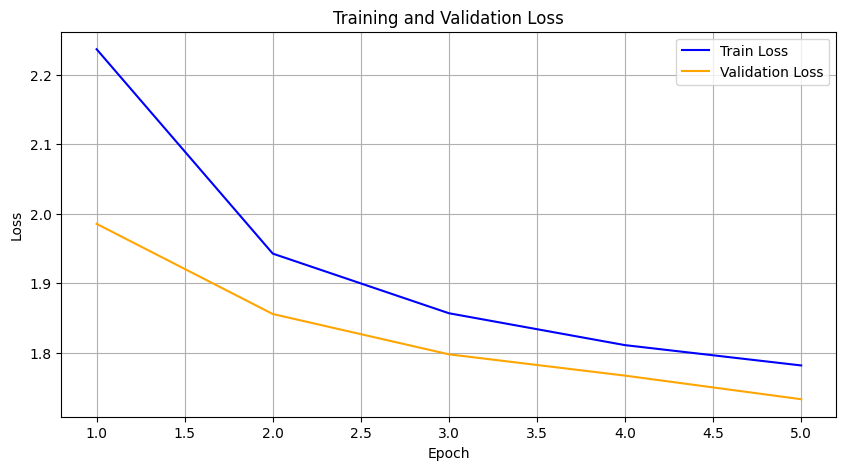

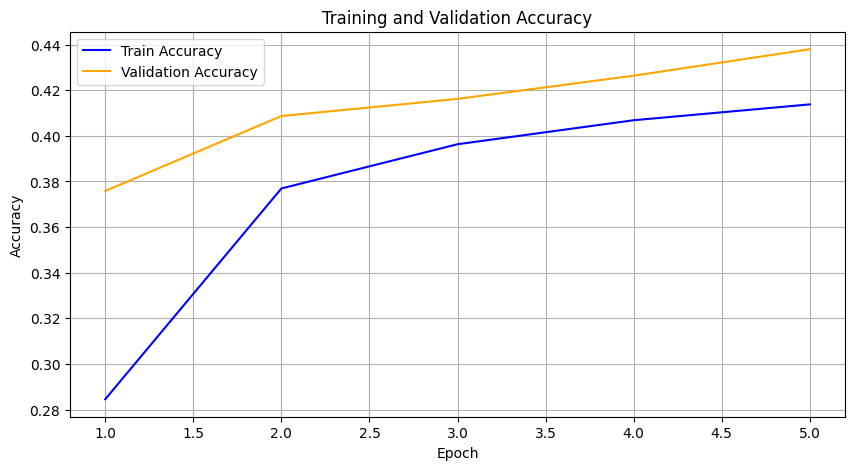

In [68]:
model1 = StyleResNet50_1()
trained_model, train_losses, valid_losses, train_accuracies, valid_accuracies = train_model(model1, 'model_50_1', train_loader, val_loader, device, num_epochs = 5, clip_gradient=None)

c:\Users\anson\Documents\Projects\Python\AI_Art_Curation_System\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\anson\Documents\Projects\Python\AI_Art_Curation_System\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 948/948 [03:45<00:00,  4.20it/s]


Epoch [1/5], Step [948/948], Training Loss: 2.2104, Training Accuracy: 0.2893, Validation Loss: 1.8882, Validation Accuracy: 0.3985


100%|██████████| 948/948 [03:06<00:00,  5.08it/s]


Epoch [2/5], Step [948/948], Training Loss: 1.9594, Training Accuracy: 0.3559, Validation Loss: 1.7915, Validation Accuracy: 0.4179


100%|██████████| 948/948 [03:07<00:00,  5.05it/s]


Epoch [3/5], Step [948/948], Training Loss: 1.8934, Training Accuracy: 0.3752, Validation Loss: 1.7441, Validation Accuracy: 0.4303


100%|██████████| 948/948 [04:04<00:00,  3.87it/s]


Epoch [4/5], Step [948/948], Training Loss: 1.8590, Training Accuracy: 0.3849, Validation Loss: 1.7231, Validation Accuracy: 0.4410


100%|██████████| 948/948 [03:57<00:00,  4.00it/s]


Epoch [5/5], Step [948/948], Training Loss: 1.8382, Training Accuracy: 0.3892, Validation Loss: 1.7038, Validation Accuracy: 0.4437
elapsed time: 1228.6836795806885


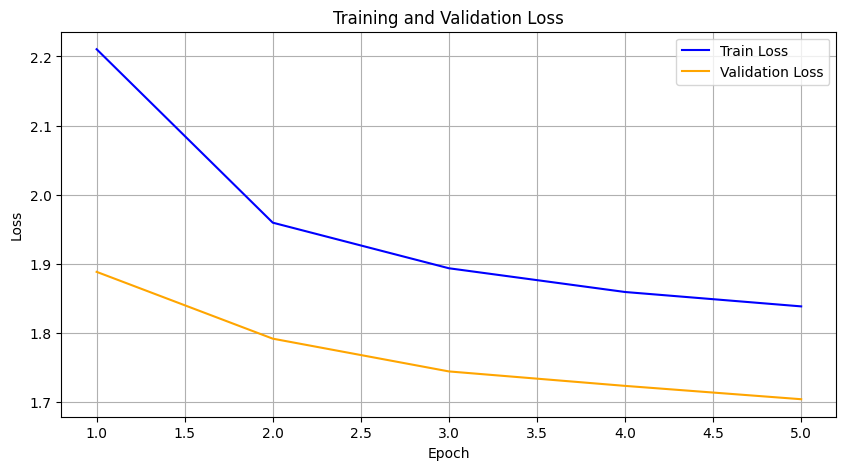

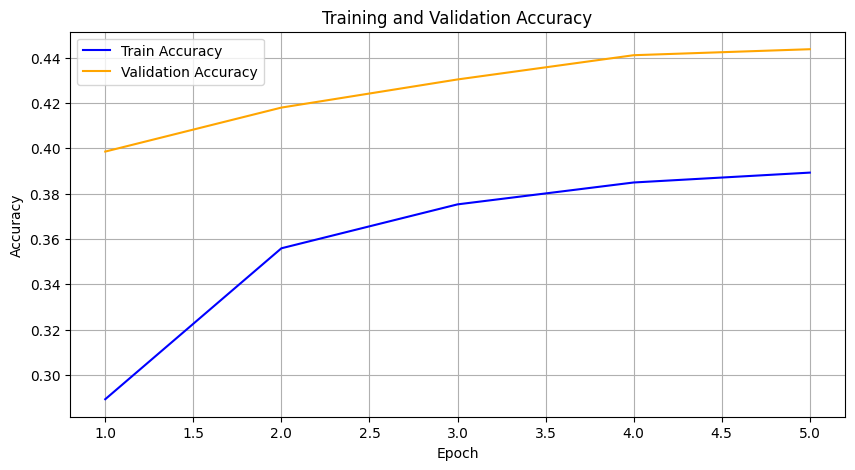

In [17]:
model2 = StyleResNet50_2()
trained_model, train_losses, valid_losses, train_accuracies, valid_accuracies = train_model(model2, 'model_50_2', train_loader, val_loader, device, num_epochs = 5, clip_gradient=None)

c:\Users\anson\Documents\Projects\Python\AI_Art_Curation_System\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\anson\Documents\Projects\Python\AI_Art_Curation_System\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 474/474 [03:47<00:00,  2.09it/s]


Epoch [1/10], Step [474/474], Training Loss: 2.0707, Training Accuracy: 0.3376, Validation Loss: 1.8313, Validation Accuracy: 0.4026


100%|██████████| 474/474 [03:42<00:00,  2.13it/s]


Epoch [2/10], Step [474/474], Training Loss: 1.7854, Training Accuracy: 0.4111, Validation Loss: 1.7361, Validation Accuracy: 0.4331


100%|██████████| 474/474 [03:02<00:00,  2.59it/s]


Epoch [3/10], Step [474/474], Training Loss: 1.7191, Training Accuracy: 0.4304, Validation Loss: 1.6946, Validation Accuracy: 0.4356


100%|██████████| 474/474 [03:02<00:00,  2.59it/s]


Epoch [4/10], Step [474/474], Training Loss: 1.6815, Training Accuracy: 0.4401, Validation Loss: 1.6643, Validation Accuracy: 0.4459


100%|██████████| 474/474 [03:34<00:00,  2.21it/s]


Epoch [5/10], Step [474/474], Training Loss: 1.6543, Training Accuracy: 0.4478, Validation Loss: 1.6660, Validation Accuracy: 0.4563


100%|██████████| 474/474 [04:03<00:00,  1.94it/s]


Epoch [6/10], Step [474/474], Training Loss: 1.6313, Training Accuracy: 0.4538, Validation Loss: 1.6358, Validation Accuracy: 0.4583


100%|██████████| 474/474 [03:51<00:00,  2.05it/s]


Epoch [7/10], Step [474/474], Training Loss: 1.6100, Training Accuracy: 0.4606, Validation Loss: 1.6158, Validation Accuracy: 0.4649


100%|██████████| 474/474 [03:10<00:00,  2.49it/s]


Epoch [8/10], Step [474/474], Training Loss: 1.5940, Training Accuracy: 0.4661, Validation Loss: 1.5995, Validation Accuracy: 0.4640


100%|██████████| 474/474 [03:06<00:00,  2.54it/s]


Epoch [9/10], Step [474/474], Training Loss: 1.5740, Training Accuracy: 0.4706, Validation Loss: 1.5855, Validation Accuracy: 0.4703


100%|██████████| 474/474 [04:04<00:00,  1.94it/s]


Epoch [10/10], Step [474/474], Training Loss: 1.5584, Training Accuracy: 0.4766, Validation Loss: 1.5736, Validation Accuracy: 0.4748
elapsed time: 2399.532497406006


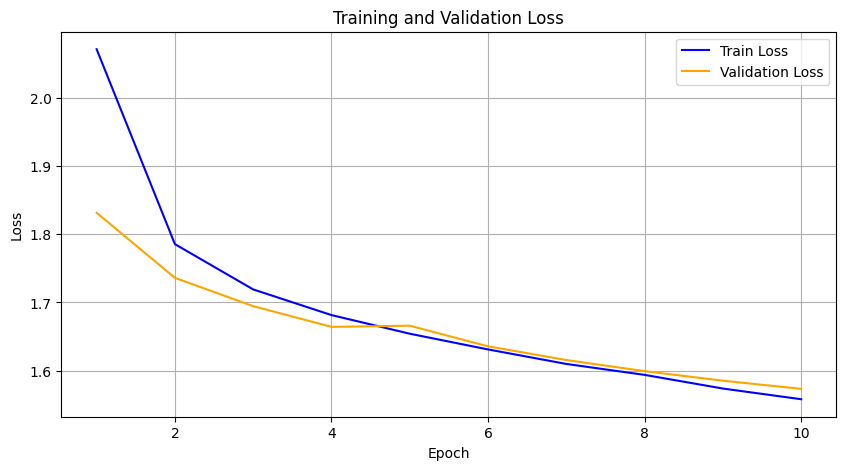

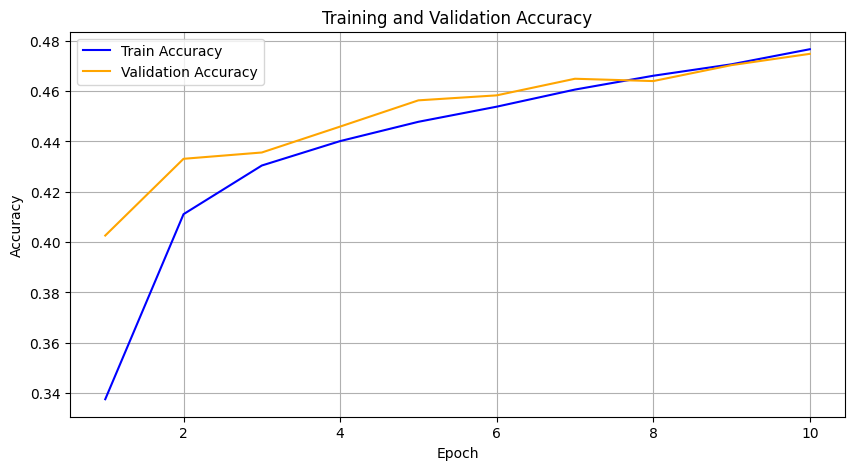

In [26]:
model3 = StyleResNet50_2(prob=0.1)
trained_model, train_losses, valid_losses, train_accuracies, valid_accuracies = train_model(model3, 'model_50_2_batch_128', train_loader, val_loader, device, num_epochs = 10, clip_gradient=None)

100%|██████████| 474/474 [03:46<00:00,  2.09it/s]


Epoch [1/10], Step [474/474], Training Loss: 2.1526, Training Accuracy: 0.3068, Validation Loss: 1.8686, Validation Accuracy: 0.3907


100%|██████████| 474/474 [03:47<00:00,  2.08it/s]


Epoch [2/10], Step [474/474], Training Loss: 1.8659, Training Accuracy: 0.3871, Validation Loss: 1.7587, Validation Accuracy: 0.4276


100%|██████████| 474/474 [04:02<00:00,  1.95it/s]


Epoch [3/10], Step [474/474], Training Loss: 1.7973, Training Accuracy: 0.4067, Validation Loss: 1.7202, Validation Accuracy: 0.4388


100%|██████████| 474/474 [03:53<00:00,  2.03it/s]


Epoch [4/10], Step [474/474], Training Loss: 1.7614, Training Accuracy: 0.4158, Validation Loss: 1.6856, Validation Accuracy: 0.4443


100%|██████████| 474/474 [04:02<00:00,  1.95it/s]


Epoch [5/10], Step [474/474], Training Loss: 1.7332, Training Accuracy: 0.4225, Validation Loss: 1.6672, Validation Accuracy: 0.4517


100%|██████████| 474/474 [04:02<00:00,  1.96it/s]


Epoch [6/10], Step [474/474], Training Loss: 1.7090, Training Accuracy: 0.4284, Validation Loss: 1.6479, Validation Accuracy: 0.4534


100%|██████████| 474/474 [03:56<00:00,  2.01it/s]


Epoch [7/10], Step [474/474], Training Loss: 1.6935, Training Accuracy: 0.4327, Validation Loss: 1.6357, Validation Accuracy: 0.4600


100%|██████████| 474/474 [03:34<00:00,  2.21it/s]


Epoch [8/10], Step [474/474], Training Loss: 1.6815, Training Accuracy: 0.4384, Validation Loss: 1.6255, Validation Accuracy: 0.4608


100%|██████████| 474/474 [04:06<00:00,  1.92it/s]


Epoch [9/10], Step [474/474], Training Loss: 1.6665, Training Accuracy: 0.4421, Validation Loss: 1.6075, Validation Accuracy: 0.4689


100%|██████████| 474/474 [04:07<00:00,  1.92it/s]


Epoch [10/10], Step [474/474], Training Loss: 1.6515, Training Accuracy: 0.4468, Validation Loss: 1.6036, Validation Accuracy: 0.4623
elapsed time: 2672.293226957321


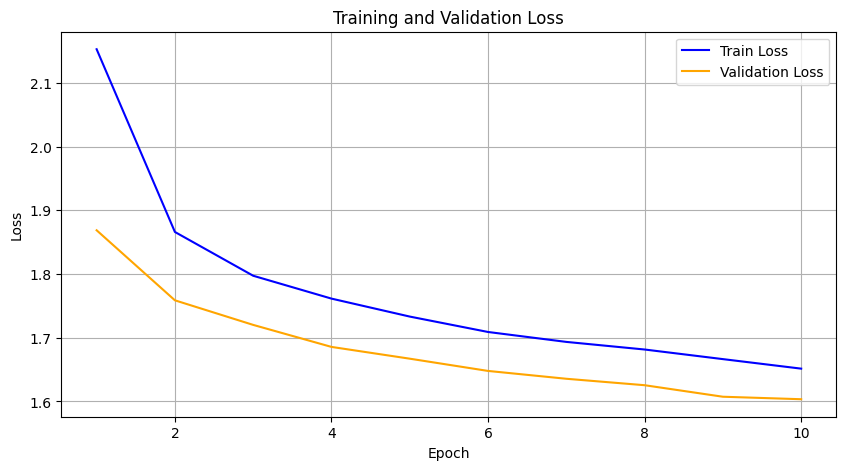

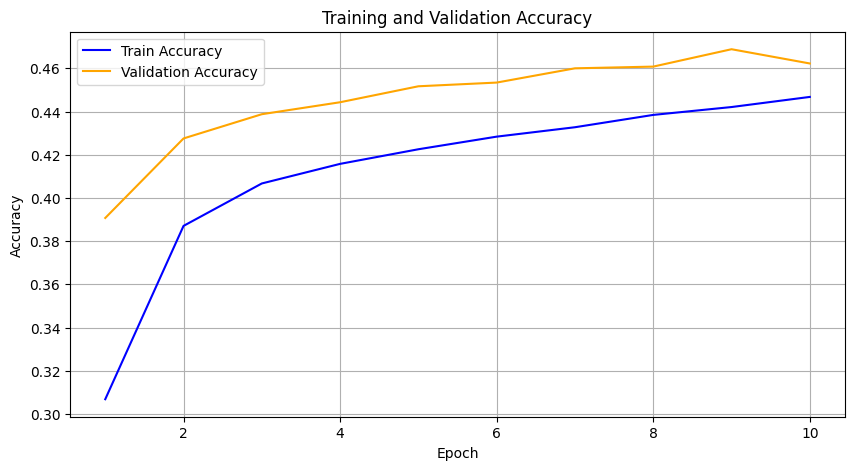

In [28]:
model4 = StyleResNet50_2(prob=0.3)
trained_model, train_losses, valid_losses, train_accuracies, valid_accuracies = train_model(model4, 'model_50_4_batch_128', train_loader, val_loader, device, num_epochs = 10, clip_gradient=None)

100%|██████████| 474/474 [03:43<00:00,  2.12it/s]


Epoch [1/10], Step [474/474], Training Loss: 1.5445, Training Accuracy: 0.4795, Validation Loss: 1.5689, Validation Accuracy: 0.4753


100%|██████████| 474/474 [03:50<00:00,  2.06it/s]


Epoch [2/10], Step [474/474], Training Loss: 1.5298, Training Accuracy: 0.4842, Validation Loss: 1.5494, Validation Accuracy: 0.4835


100%|██████████| 474/474 [03:57<00:00,  2.00it/s]


Epoch [3/10], Step [474/474], Training Loss: 1.5155, Training Accuracy: 0.4888, Validation Loss: 1.5519, Validation Accuracy: 0.4792


100%|██████████| 474/474 [04:02<00:00,  1.96it/s]


Epoch [4/10], Step [474/474], Training Loss: 1.4979, Training Accuracy: 0.4933, Validation Loss: 1.5422, Validation Accuracy: 0.4809


100%|██████████| 474/474 [04:03<00:00,  1.95it/s]


Epoch [5/10], Step [474/474], Training Loss: 1.4866, Training Accuracy: 0.4984, Validation Loss: 1.5270, Validation Accuracy: 0.4916


100%|██████████| 474/474 [04:02<00:00,  1.95it/s]


Epoch [6/10], Step [474/474], Training Loss: 1.4704, Training Accuracy: 0.5035, Validation Loss: 1.5178, Validation Accuracy: 0.4916


100%|██████████| 474/474 [03:55<00:00,  2.01it/s]


Epoch [7/10], Step [474/474], Training Loss: 1.4563, Training Accuracy: 0.5076, Validation Loss: 1.5192, Validation Accuracy: 0.4943


100%|██████████| 474/474 [04:05<00:00,  1.93it/s]


Epoch [8/10], Step [474/474], Training Loss: 1.4451, Training Accuracy: 0.5116, Validation Loss: 1.5071, Validation Accuracy: 0.4914


100%|██████████| 474/474 [04:00<00:00,  1.97it/s]


Epoch [9/10], Step [474/474], Training Loss: 1.4306, Training Accuracy: 0.5160, Validation Loss: 1.4989, Validation Accuracy: 0.4954


100%|██████████| 474/474 [04:18<00:00,  1.83it/s]


Epoch [10/10], Step [474/474], Training Loss: 1.4193, Training Accuracy: 0.5200, Validation Loss: 1.4988, Validation Accuracy: 0.4920
elapsed time: 2725.271726131439


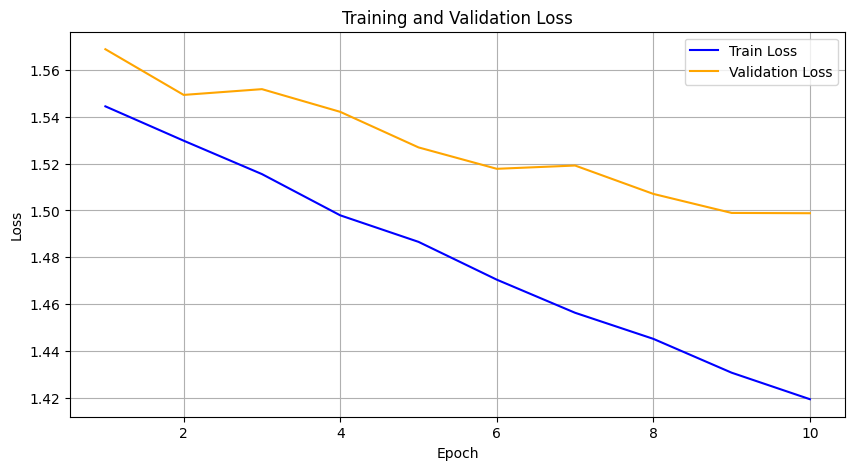

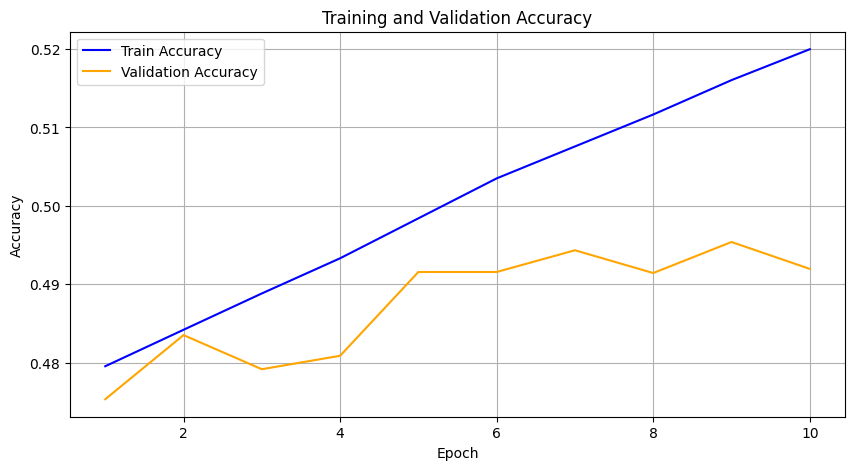

In [30]:
model_best = joblib.load('C:\\Users\\anson\\Documents\\Projects\\Python\\AI_Art_Curation_System\\outputs\\model_50_2_batch_128_epoch10.joblib')
trained_model, train_losses, valid_losses, train_accuracies, valid_accuracies = train_model(model_best, 'model_50_2_batch_128_p2', train_loader, val_loader, device, num_epochs = 10, clip_gradient=None)

# Evaluate Function

In [ ]:
def precision_at_k(y_true, y_pred, k=3):
    top_k_indices = np.argsort(y_pred, axis=1)[:, -k:]  # Get indices of top k predictions for each example
    num_examples = len(y_true)
    correct_predictions = 0
    for i in range(num_examples):
        if y_true[i] in top_k_indices[i]:
            correct_predictions += 1
    precision = correct_predictions
    return precision

In [ ]:
def evaluate_model(model, data_loader, device):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0
    total_precision = 0
    total_correct = 0
    total_samples = 0
    y_hat_epoch = []
    y_true_epoch = []

    i = 0

    criterion = nn.CrossEntropyLoss()
    with torch.no_grad():

        for data, labels in data_loader:
          data, labels = data.to(device), labels.to(device)
          output = model(data)
          loss = criterion(output, labels)
          total_loss += loss.item() * data.size(0)

          pred = output.max(1, keepdim=True)[1]
          total_correct += pred.eq(labels.view_as(pred)).sum().item()

          precision = precision_at_k(labels.cpu().numpy(), output.cpu().numpy(), k=3)
          total_precision += precision

          total_samples += data.size(0)
          y_hat_epoch.append(pred.cpu().numpy())
          y_true_epoch.append(labels.cpu().numpy())

    y_hat_epoch = np.concatenate(y_hat_epoch, axis=None)
    y_true_epoch = np.concatenate(y_true_epoch, axis=None)

    precision_k = total_precision / total_samples
    average_loss = total_loss / total_samples
    accuracies = total_correct / total_samples
    scores = precision_recall_fscore_support(np.array(y_true_epoch), np.array(y_hat_epoch))
    results = pd.DataFrame({'loss': average_loss, 'accuracy': accuracies, 'topk': precision_k,
                            'precision': scores[0], 'recall': scores[1], 'f1': scores[2]})
    #results.to_csv(f'/content/drive/MyDrive/UofT/MIE1517/project/fine_tune/Metrics results.csv')

    return average_loss, accuracies, precision_k, scores, y_true_epoch, y_hat_epoch,

# Evaluate

### metrics

In [ ]:
best_model = joblib.load(f'/content/drive/MyDrive/UofT/MIE1517/project/fine_tune/resnet50_wo_l2_epoch3.joblib')
train_average_loss, train_accuracies, train_precision_k, train_scores, y_ture_train, y_hat_train = evaluate_model(best_model, train_loader_subset, device)

In [ ]:
val_average_loss, val_accuracies, val_precision_k, val_scores, y_true_val, y_hat_val = evaluate_model(best_model, val_loader_subset, device)
test_average_loss, test_accuracies, test_precision_k, test_scores, y_true_test, y_hat_test = evaluate_model(best_model, test_loader_subset, device)

In [ ]:
losses = pd.DataFrame({'losses': [train_average_loss, val_average_loss, test_average_loss],
                       'accuracy': [train_accuracies, val_accuracies, test_accuracies],
                       'k accuracy': [train_precision_k, val_precision_k, test_precision_k]})
losses.index = ['train', 'val', 'test']

losses.to_csv(f'/content/drive/MyDrive/UofT/MIE1517/project/metrics/losses.csv')

In [ ]:
losses

,losses,accuracy,k accuracy
train,0.591562,0.808632,0.963292
val,1.245010,0.583574,0.858589
test,1.234070,0.593321,0.857164


In [ ]:
precision_metrics = pd.DataFrame({'train precision': train_scores[0], 'val precision': val_scores[0], 'test precision': test_scores[0],
                                  'train recall':train_scores[1], 'val recall': val_scores[1], 'test recall': test_scores[1],
                                  'train f1': train_scores[2], 'val f1': val_scores[2], 'test f1': test_scores[2]})
precision_metrics.index =  used_class
precision_metrics.to_csv(f'/content/drive/MyDrive/UofT/MIE1517/project/metrics/precision metrics.csv')

In [ ]:
precision_metrics

,train precision,val precision,test precision,train recall,val recall,test recall,train f1,val f1,test f1
Abstract_Expressionism,0.851133,0.674121,0.651007,0.946043,0.758993,0.692857,0.896082,0.714044,0.671280
Art_Nouveau_Modern,0.810532,0.536765,0.600000,0.816138,0.522673,0.579775,0.813326,0.529625,0.589714
Baroque,0.861182,0.646919,0.636156,0.893779,0.659420,0.665072,0.877178,0.653110,0.650292
Cubism,0.842197,0.627451,0.669903,0.826901,0.554113,0.570248,0.834479,0.588506,0.616071
Expressionism,0.781356,0.497521,0.511364,0.723601,0.441349,0.480183,0.751371,0.467754,0.495283
Impressionism,0.803947,0.621005,0.650193,0.885813,0.744332,0.755970,0.842897,0.677098,0.699103
Naive_Art_Primitivism,0.700426,0.473186,0.460064,0.841083,0.655022,0.657534,0.764337,0.549451,0.541353
Northern_Renaissance,0.825787,0.629851,0.602446,0.948959,0.742958,0.788000,0.883099,0.681745,0.682842
Post_Impressionism,0.697283,0.471086,0.452744,0.702390,0.508371,0.490909,0.699827,0.489019,0.471055
Realism,0.830296,0.592145,0.612103,0.796156,0.549020,0.572888,0.812868,0.569767,0.591847


### confusion matrix

In [ ]:
def plot_confusion(Y_hat, Y_test, classes, title):
  '''input: Y_hat, Y_test: list
            raw_datset: ImageFoldered data'''

  C = confusion_matrix(Y_test, Y_hat)

  C_df = pd.DataFrame(C,
                       index = classes,
                       columns = classes)

  plt.figure(figsize=(11,10), dpi=300)
  sns.heatmap(C_df, annot=True, fmt='d', cmap='Blues')
  plt.title(f'Confusion Matrix of {title}')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.tight_layout()
  plt.show()
  return C

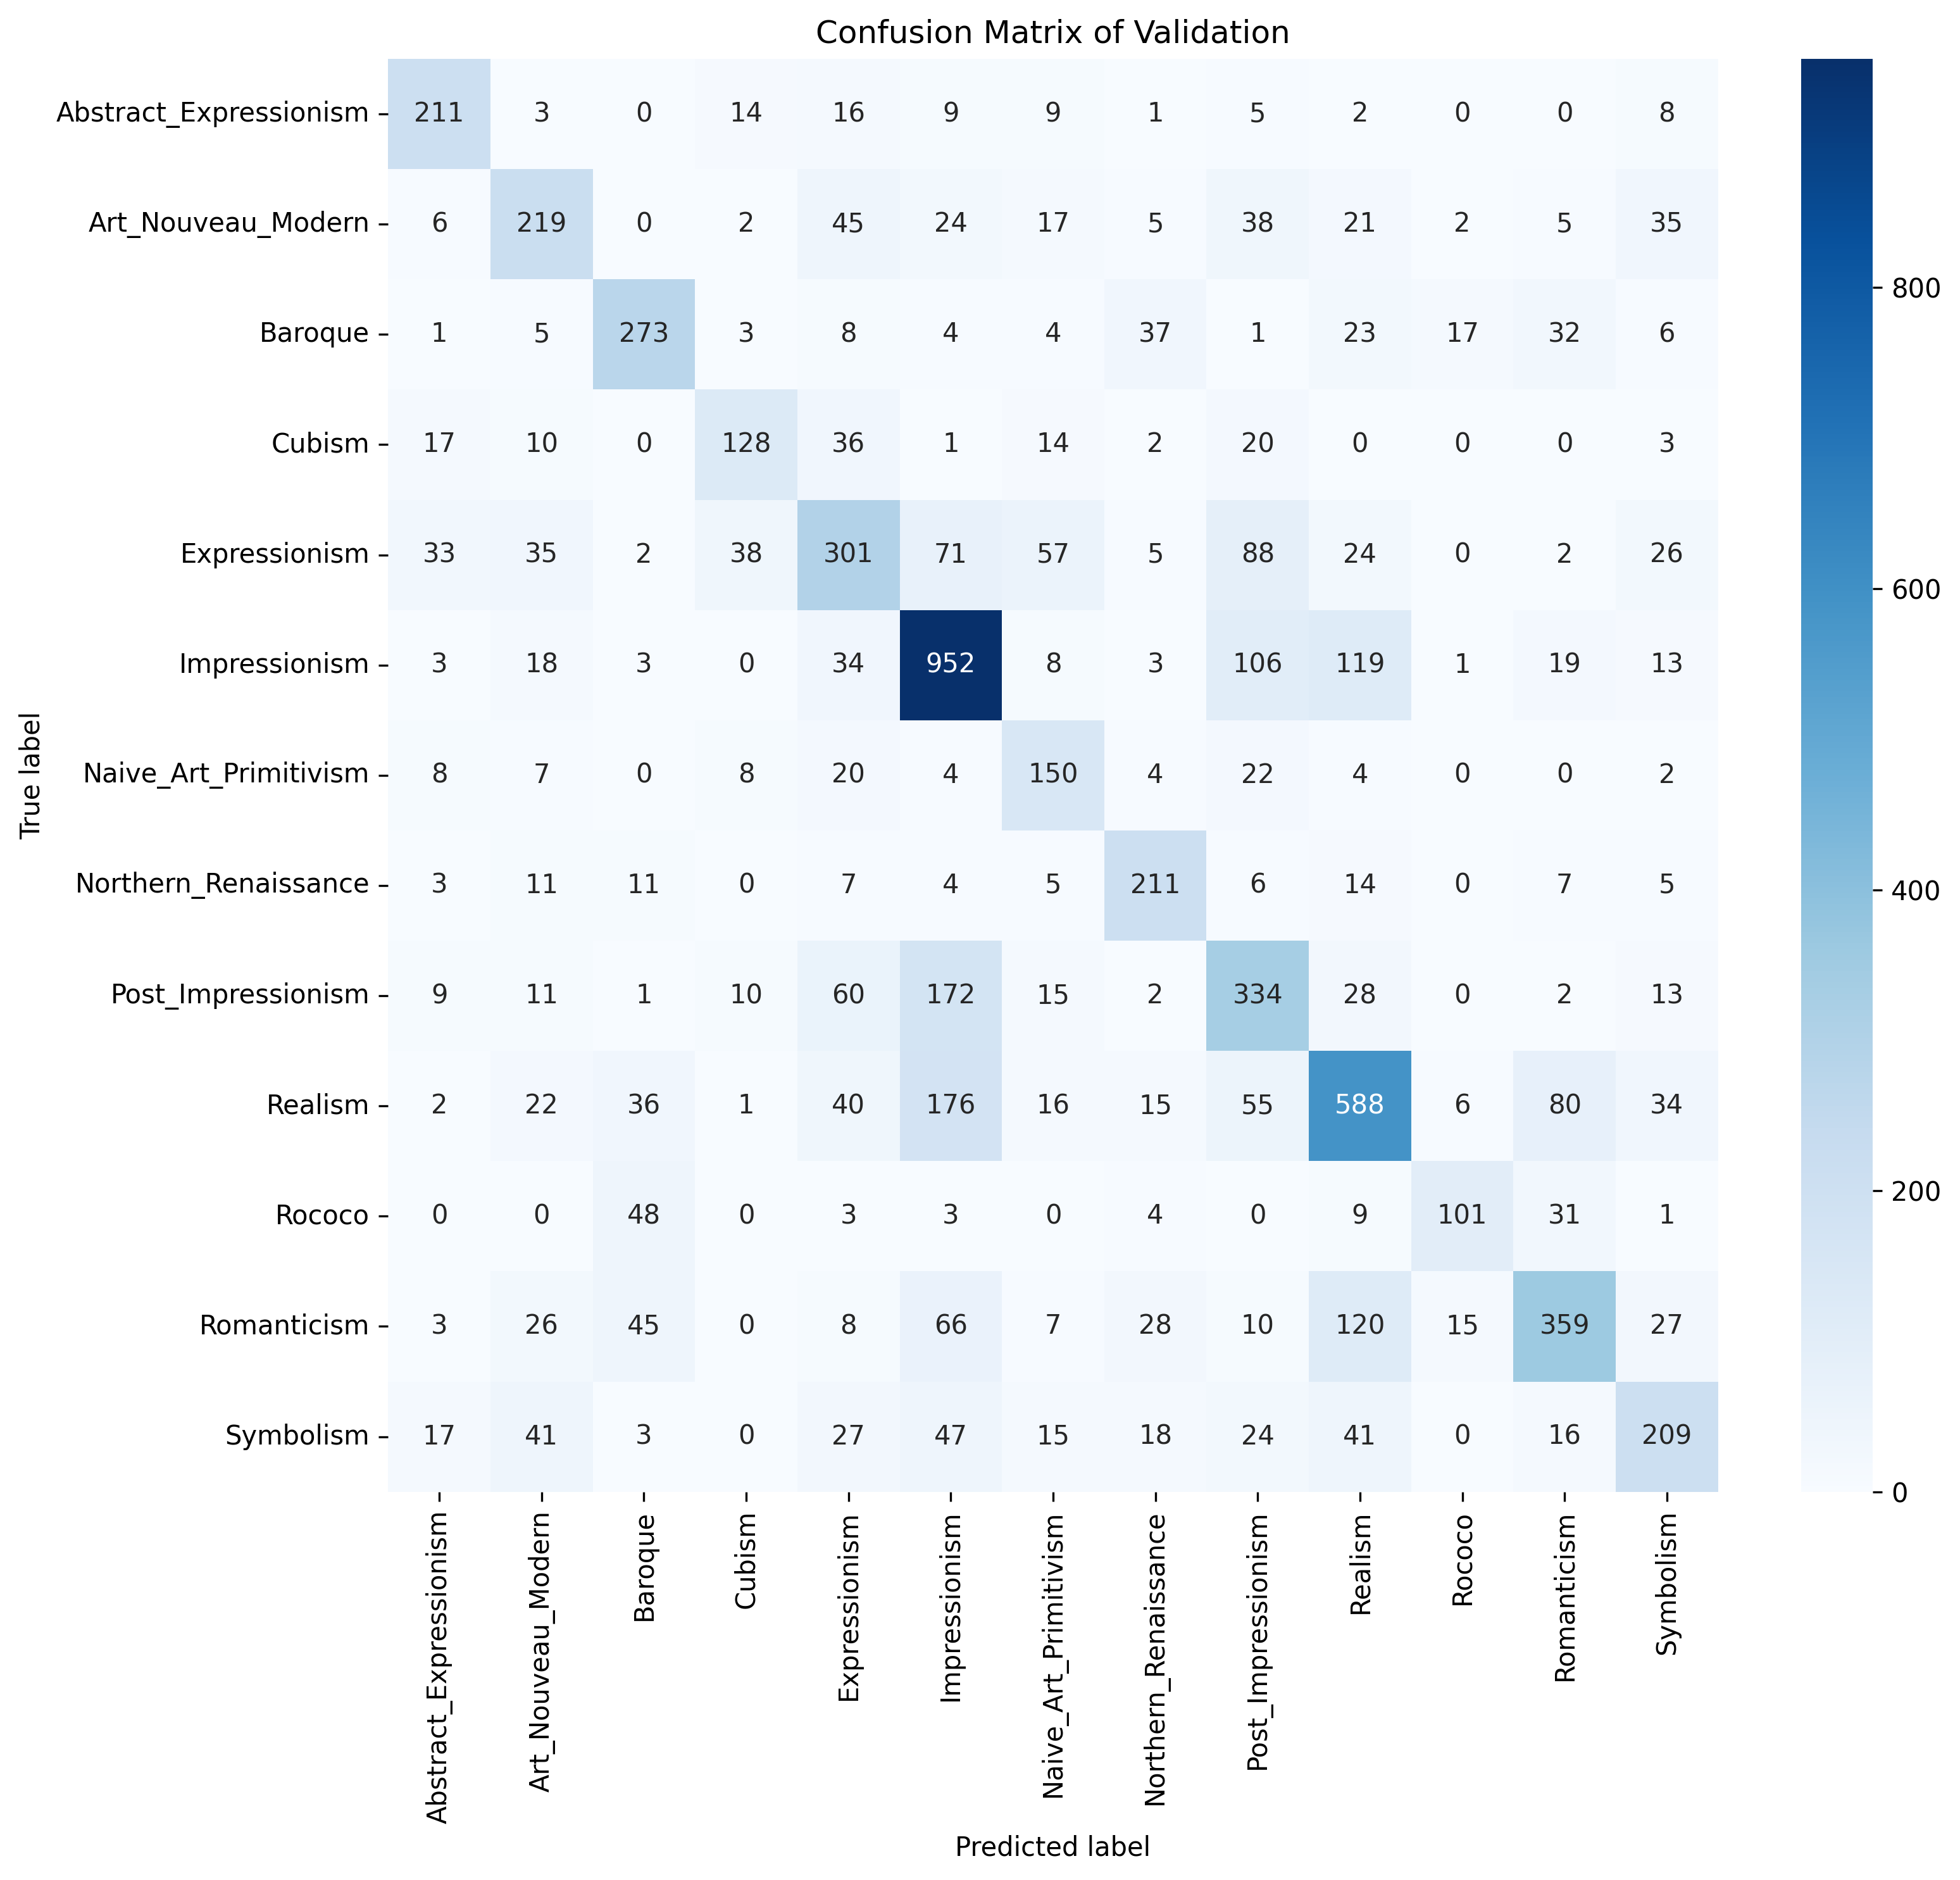

In [ ]:
C_val = plot_confusion(y_hat_val, y_true_val, used_class, 'Validation')

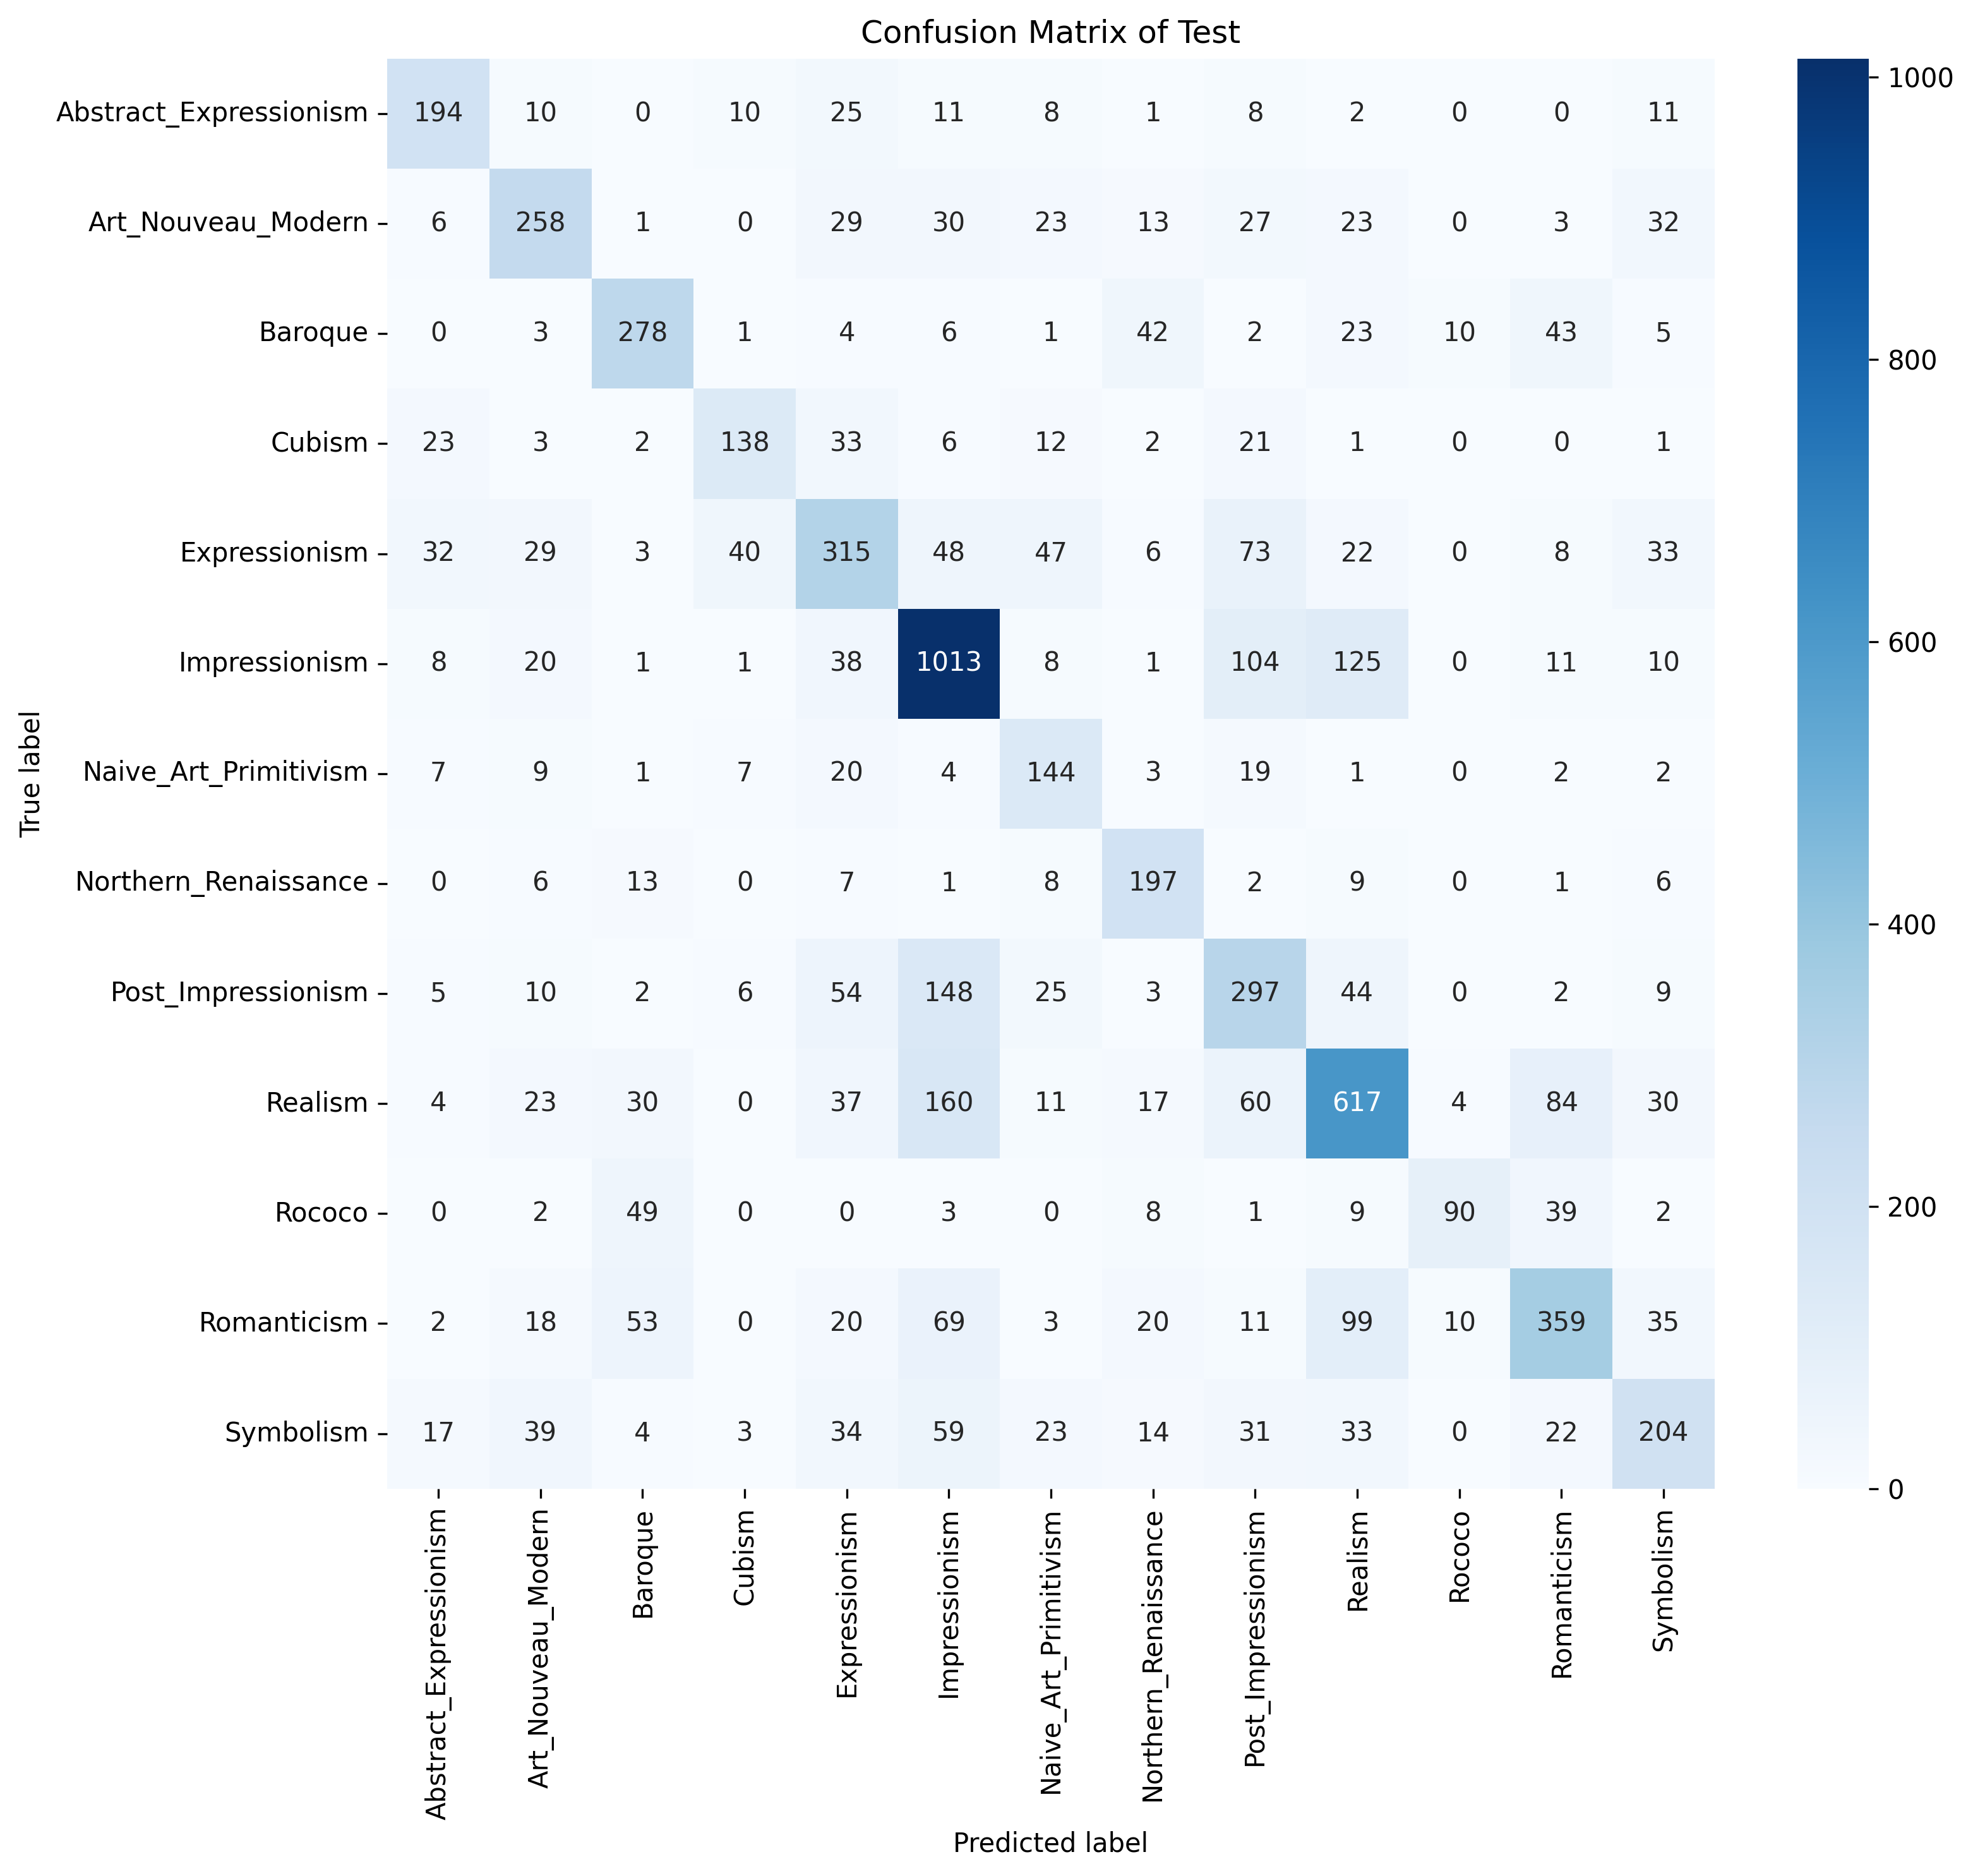

In [ ]:
C_test = plot_confusion(y_hat_test, y_true_test, used_class, 'Test')

### predicted labels

In [ ]:
value_to_category = {
    0: 'Abstract_Expressionism',
    3: 'Art_Nouveau_Modern',
    4: 'Baroque',
    7: 'Cubism',
    9: 'Expressionism',
    12: 'Impressionism',
    15: 'Naive_Art_Primitivism',
    17: 'Northern_Renaissance',
    20: 'Post_Impressionism',
    21: 'Realism',
    22: 'Rococo',
    23: 'Romanticism',
    24: 'Symbolism'
}
class_numbers = list(value_to_category.keys())

predicted = pd.DataFrame()
for true_label in class_numbers:
  indices = np.where(y_true_test == true_label)[0]

  elements = y_hat_test[indices]
  counter = Counter(elements)
  sorted_counter = sorted(counter.items(), key=lambda x: x[0])
  for i in range(len(value_to_category)):
    if sorted_counter[i][0] != class_numbers[i]:
      sorted_counter.append((class_numbers[i], 0))
      sorted_counter = sorted(sorted_counter, key=lambda x: x[0])
 # print(sorted_counter)
  counts = []
  for value, count in sorted_counter:
      counts.append(count)

  while len(counts) < 12:
        counts.append(np.nan)
  predicted[f'{value_to_category[true_label]}'] = counts
predicted.index = used_class
predicted.index.name = 'predicted class'

predicted.to_csv(f'/content/drive/MyDrive/UofT/MIE1517/project/metrics/predicted classes.csv')

In [ ]:
predicted

,Abstract_Expressionism,Art_Nouveau_Modern,Baroque,Cubism,Expressionism,Impressionism,Naive_Art_Primitivism,Northern_Renaissance,Post_Impressionism,Realism,Rococo,Romanticism,Symbolism
predicted class,,,,,,,,,,,,,
Abstract_Expressionism,194,6,0,23,32,8,7,0,5,4,0,2,17
Art_Nouveau_Modern,10,258,3,3,29,20,9,6,10,23,2,18,39
Baroque,0,1,278,2,3,1,1,13,2,30,49,53,4
Cubism,10,0,1,138,40,1,7,0,6,0,0,0,3
Expressionism,25,29,4,33,315,38,20,7,54,37,0,20,34
Impressionism,11,30,6,6,48,1013,4,1,148,160,3,69,59
Naive_Art_Primitivism,8,23,1,12,47,8,144,8,25,11,0,3,23
Northern_Renaissance,1,13,42,2,6,1,3,197,3,17,8,20,14
Post_Impressionism,8,27,2,21,73,104,19,2,297,60,1,11,31


In [ ]:
curve = pd.read_csv(f'/content/drive/MyDrive/UofT/MIE1517/project/fine_tune/resnet50_wo_l2_results.csv')
curve

,Unnamed: 0,train loss,valid loss,train accuracy,valid accuracy,iteration
0,0,1.236285,1.401271,0.578333,0.516628,866
1,1,0.905961,1.267968,0.687627,0.559717,1731
2,2,0.591562,1.245010,0.808632,0.583574,2596
3,3,0.437250,1.367412,0.853673,0.576200,3461
4,4,0.282420,1.476270,0.913299,0.574320,4326


In [ ]:
def plot_curves(train_losses, valid_losses, train_accuracies, valid_accuracies):
    epochs = range(1, len(train_losses) + 1)
    # Plot Loss Curve
    plt.figure(figsize=(10, 5), dpi=300)
    plt.plot(epochs, train_losses, label='Train Loss', color='blue')
    plt.plot(epochs, valid_losses, label='Validation Loss', color='orange')
    plt.xlabel('epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plot Accuracy Curve
    plt.figure(figsize=(10, 5), dpi=300)
    plt.plot(epochs, train_accuracies, label='Train Accuracy', color='blue')
    plt.plot(epochs, valid_accuracies, label='Validation Accuracy', color='orange')
    plt.xlabel('epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

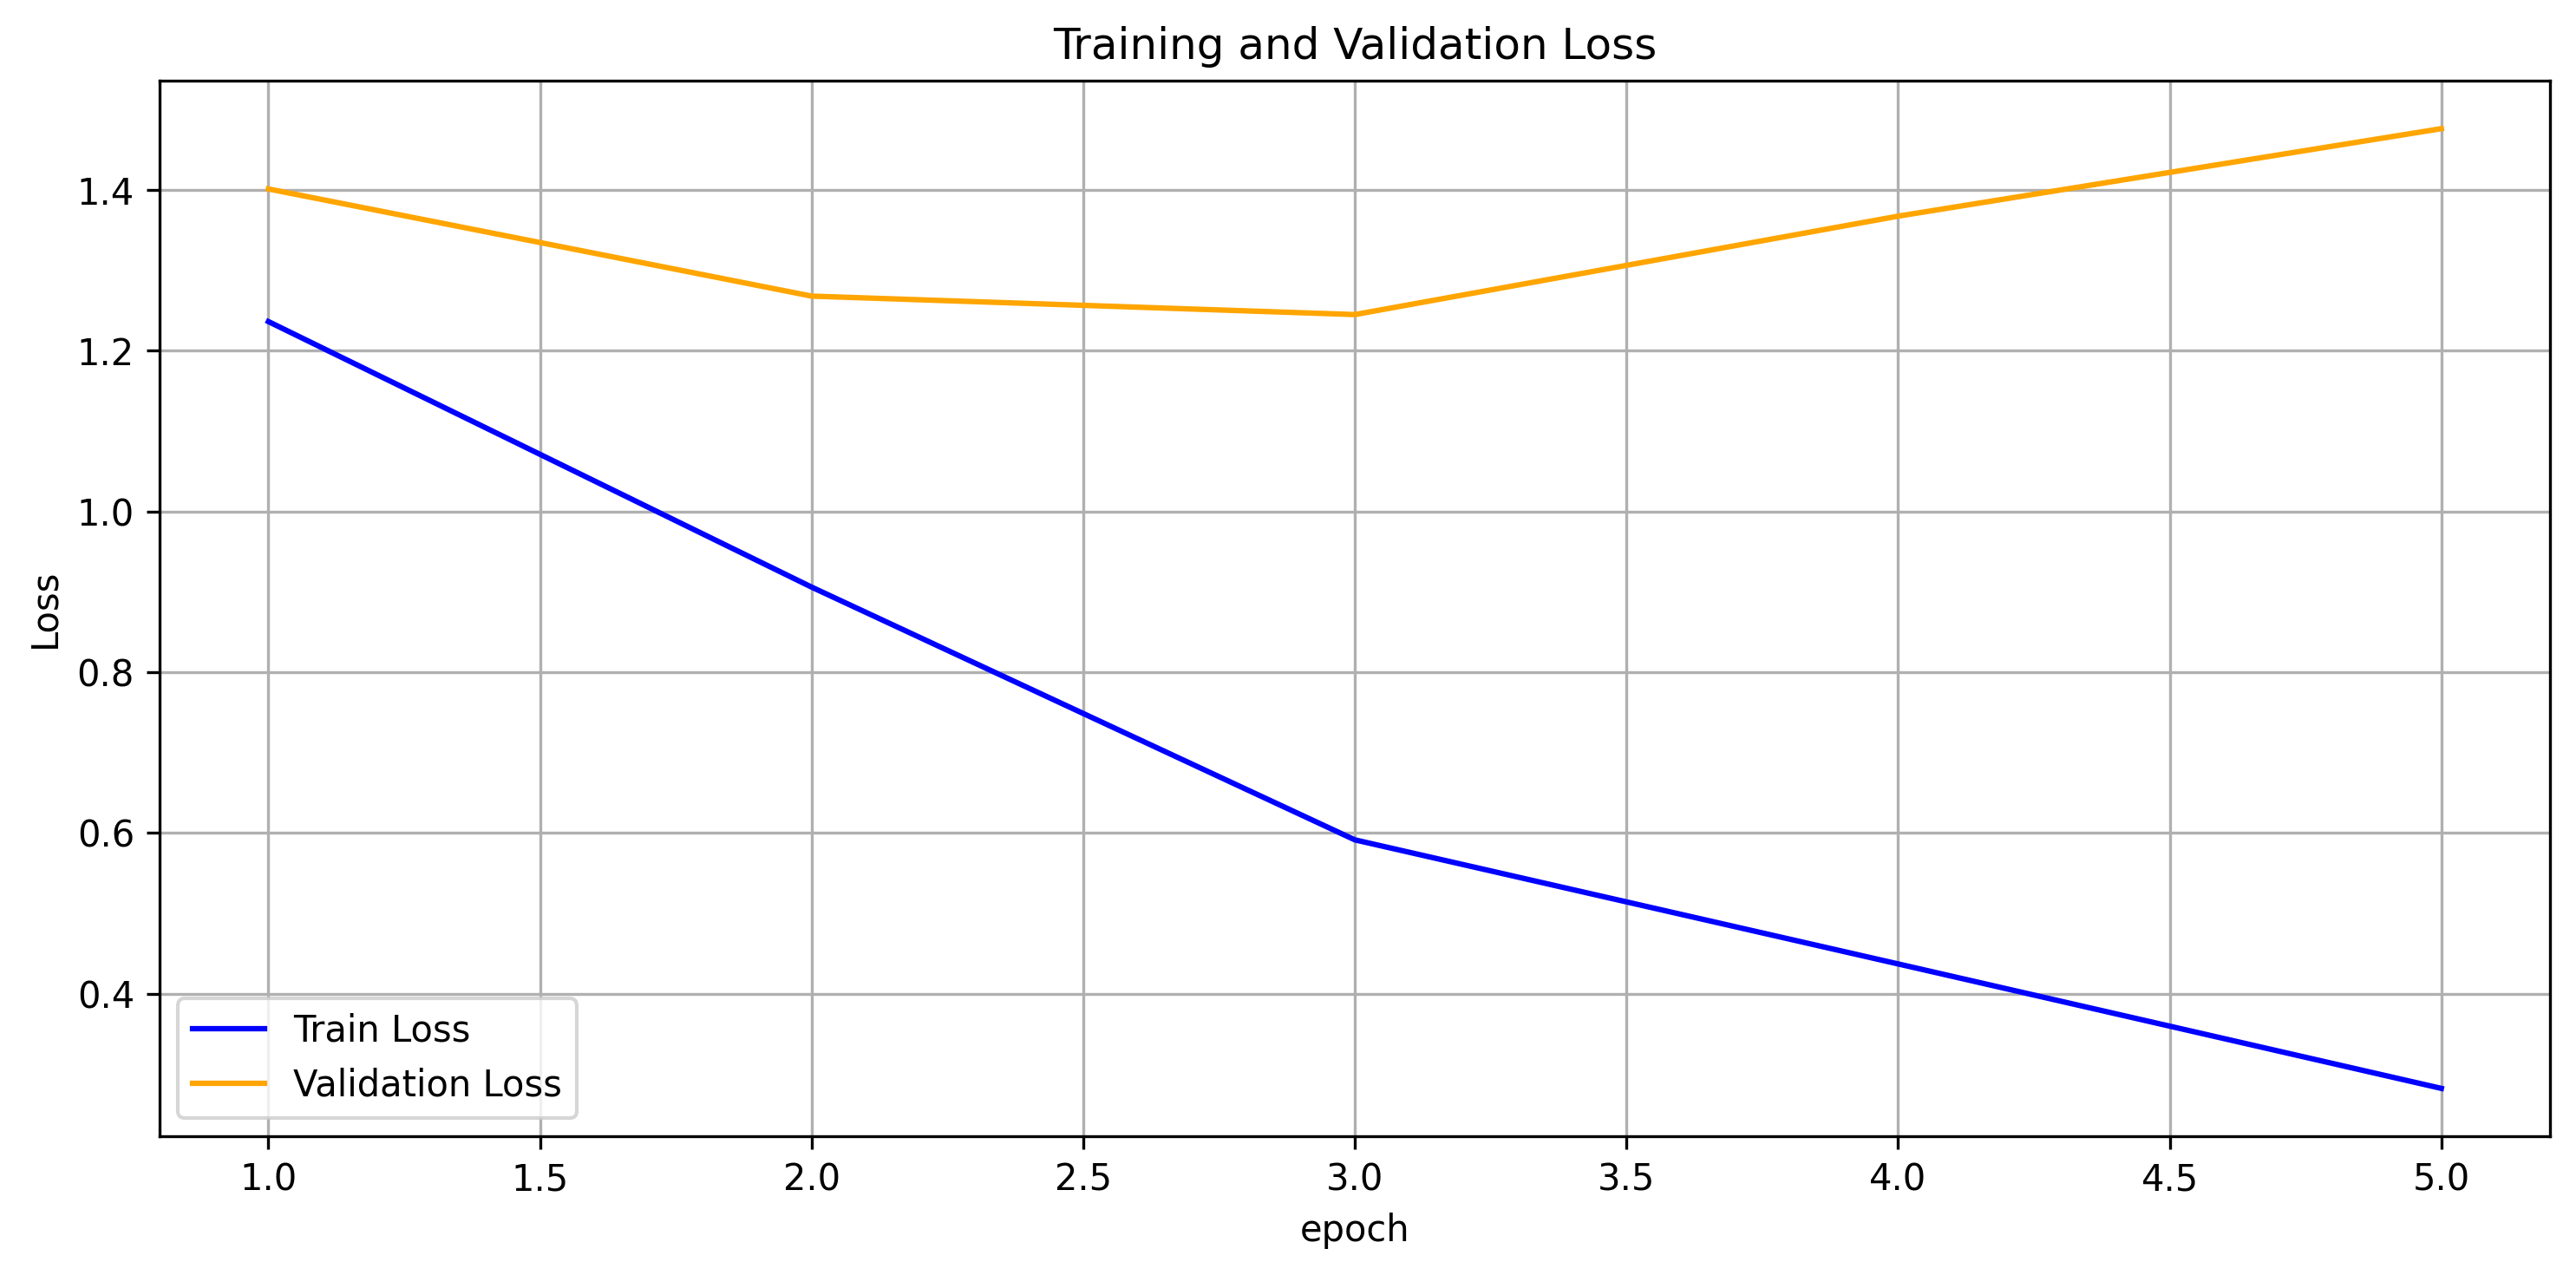

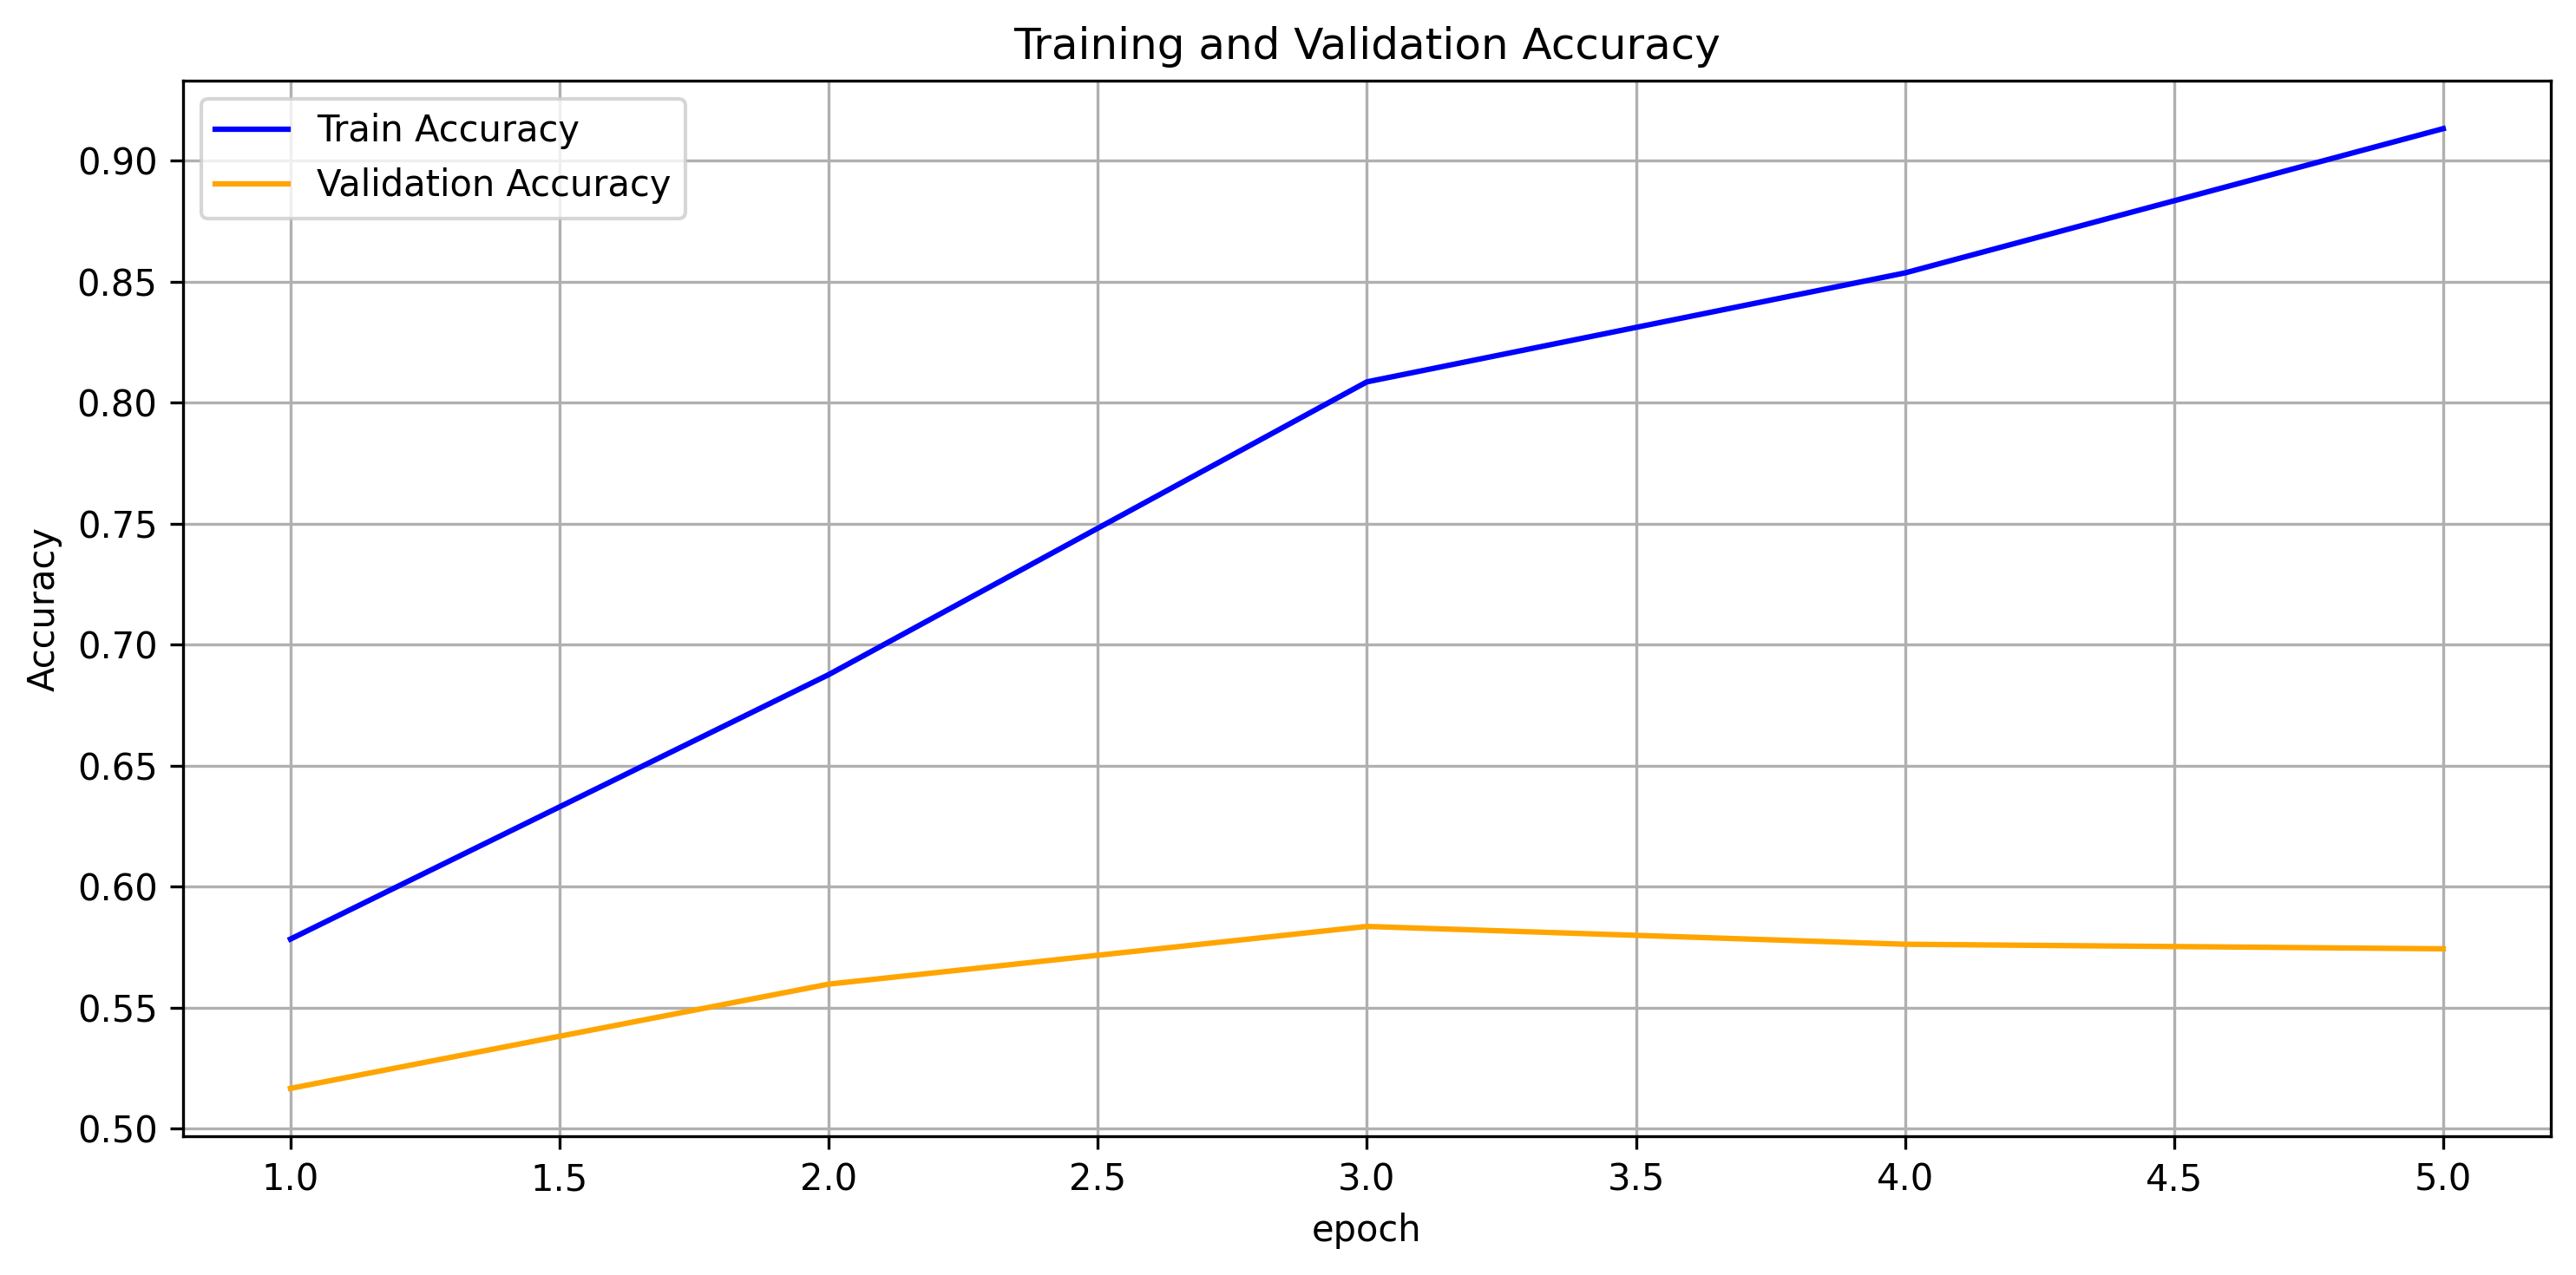

In [ ]:
plot_curves(curve['train loss'], curve['valid loss'], curve['train accuracy'], curve['valid accuracy'])